# 0. Set up (Drive, Roboflow, pipinstall)

Source: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/obss/sahi/blob/main/demo/inference_for_yolov5.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/obss/sahi.git

In [ ]:
!pip install -q roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PedpBLYKs7QDbTD3nUH3")
project = rf.workspace("fa23ai02-objdetection-2").project("trainable-iot")
dataset = project.version(2).download("yolov5")


In [ ]:
%pip install -q -U torch yolov5 ultralytics

In [ ]:
# @title Fix: yolov5/general.py, otherwise, the code won't run
%%writefile /usr/local/lib/python3.10/dist-packages/yolov5/utils/general.py

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
General utils
"""

import contextlib
import glob
import inspect
import logging
import logging.config
import math
import os
import platform
import random
import re
import signal
import subprocess
import sys
import time
import urllib
from copy import deepcopy
from datetime import datetime
from itertools import repeat
from multiprocessing.pool import ThreadPool
from pathlib import Path
from subprocess import check_output
from tarfile import is_tarfile
from typing import Optional
from zipfile import ZipFile, is_zipfile

import cv2
import numpy as np
import pandas as pd
import pkg_resources as pkg
import torch
import torchvision
import yaml
from ultralytics.utils.checks import check_requirements

from yolov5.utils import TryExcept, emojis
from yolov5.utils.downloads import curl_download, gsutil_getsize
from yolov5.utils.metrics import box_iou, fitness

FILE = Path(__file__).resolve()
ROOT = FILE.parents[1]  # YOLOv5 root directory
RANK = int(os.getenv('RANK', -1))

# Settings
NUM_THREADS = min(8, max(1, os.cpu_count() - 1))  # number of YOLOv5 multiprocessing threads
DATASETS_DIR = Path(os.getenv('YOLOv5_DATASETS_DIR', 'datasets'))  # global datasets directory
AUTOINSTALL = str(os.getenv('YOLOv5_AUTOINSTALL', True)).lower() == 'true'  # global auto-install mode
VERBOSE = str(os.getenv('YOLOv5_VERBOSE', True)).lower() == 'true'  # global verbose mode
TQDM_BAR_FORMAT = '{l_bar}{bar:10}{r_bar}'  # tqdm bar format
FONT = 'Arial.ttf'  # https://ultralytics.com/assets/Arial.ttf

torch.set_printoptions(linewidth=320, precision=5, profile='long')
np.set_printoptions(linewidth=320, formatter={'float_kind': '{:11.5g}'.format})  # format short g, %precision=5
pd.options.display.max_columns = 10
cv2.setNumThreads(0)  # prevent OpenCV from multithreading (incompatible with PyTorch DataLoader)
os.environ['NUMEXPR_MAX_THREADS'] = str(NUM_THREADS)  # NumExpr max threads
os.environ['OMP_NUM_THREADS'] = '1' if platform.system() == 'darwin' else str(NUM_THREADS)  # OpenMP (PyTorch and SciPy)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # suppress verbose TF compiler warnings in Colab


def is_ascii(s=''):
    # Is string composed of all ASCII (no UTF) characters? (note str().isascii() introduced in python 3.7)
    s = str(s)  # convert list, tuple, None, etc. to str
    return len(s.encode().decode('ascii', 'ignore')) == len(s)


def is_chinese(s='人工智能'):
    # Is string composed of any Chinese characters?
    return bool(re.search('[\u4e00-\u9fff]', str(s)))


def is_colab():
    # Is environment a Google Colab instance?
    return 'google.colab' in sys.modules


def is_jupyter():
    """
    Check if the current script is running inside a Jupyter Notebook.
    Verified on Colab, Jupyterlab, Kaggle, Paperspace.

    Returns:
        bool: True if running inside a Jupyter Notebook, False otherwise.
    """
    with contextlib.suppress(Exception):
        from IPython import get_ipython
        return get_ipython() is not None
    return False


def is_kaggle():
    # Is environment a Kaggle Notebook?
    return os.environ.get('PWD') == '/kaggle/working' and os.environ.get('KAGGLE_URL_BASE') == 'https://www.kaggle.com'


def is_docker() -> bool:
    """Check if the process runs inside a docker container."""
    if Path('/.dockerenv').exists():
        return True
    try:  # check if docker is in control groups
        with open('/proc/self/cgroup') as file:
            return any('docker' in line for line in file)
    except OSError:
        return False


def is_writeable(dir, test=False):
    # Return True if directory has write permissions, test opening a file with write permissions if test=True
    if not test:
        return os.access(dir, os.W_OK)  # possible issues on Windows
    file = Path(dir) / 'tmp.txt'
    try:
        with open(file, 'w'):  # open file with write permissions
            pass
        file.unlink()  # remove file
        return True
    except OSError:
        return False


LOGGING_NAME = 'yolov5'


def set_logging(name=LOGGING_NAME, verbose=True):
    # sets up logging for the given name
    rank = int(os.getenv('RANK', -1))  # rank in world for Multi-GPU trainings
    level = logging.INFO if verbose and rank in {-1, 0} else logging.ERROR
    logging.config.dictConfig({
        'version': 1,
        'disable_existing_loggers': False,
        'formatters': {
            name: {
                'format': '%(message)s'}},
        'handlers': {
            name: {
                'class': 'logging.StreamHandler',
                'formatter': name,
                'level': level,}},
        'loggers': {
            name: {
                'level': level,
                'handlers': [name],
                'propagate': False,}}})


set_logging(LOGGING_NAME)  # run before defining LOGGER
LOGGER = logging.getLogger(LOGGING_NAME)  # define globally (used in train.py, val.py, detect.py, etc.)
if platform.system() == 'Windows':
    for fn in LOGGER.info, LOGGER.warning:
        setattr(LOGGER, fn.__name__, lambda x: fn(emojis(x)))  # emoji safe logging


def user_config_dir(dir='Ultralytics', env_var='YOLOV5_CONFIG_DIR'):
    # Return path of user configuration directory. Prefer environment variable if exists. Make dir if required.
    env = os.getenv(env_var)
    if env:
        path = Path(env)  # use environment variable
    else:
        cfg = {'Windows': 'AppData/Roaming', 'Linux': '.config', 'Darwin': 'Library/Application Support'}  # 3 OS dirs
        path = Path.home() / cfg.get(platform.system(), '')  # OS-specific config dir
        path = (path if is_writeable(path) else Path('/tmp')) / dir  # GCP and AWS lambda fix, only /tmp is writeable
    path.mkdir(exist_ok=True)  # make if required
    return path


CONFIG_DIR = user_config_dir()  # Ultralytics settings dir


class Profile(contextlib.ContextDecorator):
    # YOLOv5 Profile class. Usage: @Profile() decorator or 'with Profile():' context manager
    def __init__(self, t=0.0):
        self.t = t
        self.cuda = torch.cuda.is_available()

    def __enter__(self):
        self.start = self.time()
        return self

    def __exit__(self, type, value, traceback):
        self.dt = self.time() - self.start  # delta-time
        self.t += self.dt  # accumulate dt

    def time(self):
        if self.cuda:
            torch.cuda.synchronize()
        return time.time()


class Timeout(contextlib.ContextDecorator):
    # YOLOv5 Timeout class. Usage: @Timeout(seconds) decorator or 'with Timeout(seconds):' context manager
    def __init__(self, seconds, *, timeout_msg='', suppress_timeout_errors=True):
        self.seconds = int(seconds)
        self.timeout_message = timeout_msg
        self.suppress = bool(suppress_timeout_errors)

    def _timeout_handler(self, signum, frame):
        raise TimeoutError(self.timeout_message)

    def __enter__(self):
        if platform.system() != 'Windows':  # not supported on Windows
            signal.signal(signal.SIGALRM, self._timeout_handler)  # Set handler for SIGALRM
            signal.alarm(self.seconds)  # start countdown for SIGALRM to be raised

    def __exit__(self, exc_type, exc_val, exc_tb):
        if platform.system() != 'Windows':
            signal.alarm(0)  # Cancel SIGALRM if it's scheduled
            if self.suppress and exc_type is TimeoutError:  # Suppress TimeoutError
                return True


class WorkingDirectory(contextlib.ContextDecorator):
    # Usage: @WorkingDirectory(dir) decorator or 'with WorkingDirectory(dir):' context manager
    def __init__(self, new_dir):
        self.dir = new_dir  # new dir
        self.cwd = Path.cwd().resolve()  # current dir

    def __enter__(self):
        os.chdir(self.dir)

    def __exit__(self, exc_type, exc_val, exc_tb):
        os.chdir(self.cwd)


def methods(instance):
    # Get class/instance methods
    return [f for f in dir(instance) if callable(getattr(instance, f)) and not f.startswith('__')]


def print_args(args: Optional[dict] = None, show_file=True, show_func=False):
    # Print function arguments (optional args dict)
    x = inspect.currentframe().f_back  # previous frame
    file, _, func, _, _ = inspect.getframeinfo(x)
    if args is None:  # get args automatically
        args, _, _, frm = inspect.getargvalues(x)
        args = {k: v for k, v in frm.items() if k in args}
    try:
        file = Path(file).resolve().relative_to(ROOT).with_suffix('')
    except ValueError:
        file = Path(file).stem
    s = (f'{file}: ' if show_file else '') + (f'{func}: ' if show_func else '')
    LOGGER.info(colorstr(s) + ', '.join(f'{k}={v}' for k, v in args.items()))


def init_seeds(seed=0, deterministic=False):
    # Initialize random number generator (RNG) seeds https://pytorch.org/docs/stable/notes/randomness.html
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for Multi-GPU, exception safe
    # torch.backends.cudnn.benchmark = True  # AutoBatch problem https://github.com/ultralytics/yolov5/issues/9287
    if deterministic and check_version(torch.__version__, '1.12.0'):  # https://github.com/ultralytics/yolov5/pull/8213
        torch.use_deterministic_algorithms(True)
        torch.backends.cudnn.deterministic = True
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
        os.environ['PYTHONHASHSEED'] = str(seed)


def intersect_dicts(da, db, exclude=()):
    # Dictionary intersection of matching keys and shapes, omitting 'exclude' keys, using da values
    return {k: v for k, v in da.items() if k in db and all(x not in k for x in exclude) and v.shape == db[k].shape}


def get_default_args(func):
    # Get func() default arguments
    signature = inspect.signature(func)
    return {k: v.default for k, v in signature.parameters.items() if v.default is not inspect.Parameter.empty}


def get_latest_run(search_dir='.'):
    # Return path to most recent 'last.pt' in /runs (i.e. to --resume from)
    last_list = glob.glob(f'{search_dir}/**/last*.pt', recursive=True)
    return max(last_list, key=os.path.getctime) if last_list else ''


def file_age(path=__file__):
    # Return days since last file update
    dt = (datetime.now() - datetime.fromtimestamp(Path(path).stat().st_mtime))  # delta
    return dt.days  # + dt.seconds / 86400  # fractional days


def file_date(path=__file__):
    # Return human-readable file modification date, i.e. '2021-3-26'
    t = datetime.fromtimestamp(Path(path).stat().st_mtime)
    return f'{t.year}-{t.month}-{t.day}'


def file_size(path):
    # Return file/dir size (MB)
    mb = 1 << 20  # bytes to MiB (1024 ** 2)
    path = Path(path)
    if path.is_file():
        return path.stat().st_size / mb
    elif path.is_dir():
        return sum(f.stat().st_size for f in path.glob('**/*') if f.is_file()) / mb
    else:
        return 0.0


def check_online():
    # Check internet connectivity
    import socket

    def run_once():
        # Check once
        try:
            socket.create_connection(('1.1.1.1', 443), 5)  # check host accessibility
            return True
        except OSError:
            return False

    return run_once() or run_once()  # check twice to increase robustness to intermittent connectivity issues


def git_describe(path=ROOT):  # path must be a directory
    # Return human-readable git description, i.e. v5.0-5-g3e25f1e https://git-scm.com/docs/git-describe
    try:
        assert (Path(path) / '.git').is_dir()
        return check_output(f'git -C {path} describe --tags --long --always', shell=True).decode()[:-1]
    except Exception:
        return ''


@TryExcept()
@WorkingDirectory(ROOT)
def check_git_status(repo='ultralytics/yolov5', branch='master'):
    # YOLOv5 status check, recommend 'git pull' if code is out of date
    url = f'https://github.com/{repo}'
    msg = f', for updates see {url}'
    s = colorstr('github: ')  # string
    assert Path('.git').exists(), s + 'skipping check (not a git repository)' + msg
    assert check_online(), s + 'skipping check (offline)' + msg

    splits = re.split(pattern=r'\s', string=check_output('git remote -v', shell=True).decode())
    matches = [repo in s for s in splits]
    if any(matches):
        remote = splits[matches.index(True) - 1]
    else:
        remote = 'ultralytics'
        check_output(f'git remote add {remote} {url}', shell=True)
    check_output(f'git fetch {remote}', shell=True, timeout=5)  # git fetch
    local_branch = check_output('git rev-parse --abbrev-ref HEAD', shell=True).decode().strip()  # checked out
    n = int(check_output(f'git rev-list {local_branch}..{remote}/{branch} --count', shell=True))  # commits behind
    if n > 0:
        pull = 'git pull' if remote == 'origin' else f'git pull {remote} {branch}'
        s += f"⚠️ YOLOv5 is out of date by {n} commit{'s' * (n > 1)}. Use '{pull}' or 'git clone {url}' to update."
    else:
        s += f'up to date with {url} ✅'
    LOGGER.info(s)


@WorkingDirectory(ROOT)
def check_git_info(path='.'):
    # YOLOv5 git info check, return {remote, branch, commit}
    check_requirements('gitpython')
    import git
    try:
        repo = git.Repo(path)
        remote = repo.remotes.origin.url.replace('.git', '')  # i.e. 'https://github.com/ultralytics/yolov5'
        commit = repo.head.commit.hexsha  # i.e. '3134699c73af83aac2a481435550b968d5792c0d'
        try:
            branch = repo.active_branch.name  # i.e. 'main'
        except TypeError:  # not on any branch
            branch = None  # i.e. 'detached HEAD' state
        return {'remote': remote, 'branch': branch, 'commit': commit}
    except git.exc.InvalidGitRepositoryError:  # path is not a git dir
        return {'remote': None, 'branch': None, 'commit': None}


def check_python(minimum='3.7.0'):
    # Check current python version vs. required python version
    check_version(platform.python_version(), minimum, name='Python ', hard=True)


def check_version(current='0.0.0', minimum='0.0.0', name='version ', pinned=False, hard=False, verbose=False):
    # Check version vs. required version
    current, minimum = (pkg.parse_version(x) for x in (current, minimum))
    result = (current == minimum) if pinned else (current >= minimum)  # bool
    s = f'WARNING ⚠️ {name}{minimum} is required by YOLOv5, but {name}{current} is currently installed'  # string
    if hard:
        assert result, emojis(s)  # assert min requirements met
    if verbose and not result:
        LOGGER.warning(s)
    return result


def check_img_size(imgsz, s=32, floor=0):
    # Verify image size is a multiple of stride s in each dimension
    if isinstance(imgsz, int):  # integer i.e. img_size=640
        new_size = max(make_divisible(imgsz, int(s)), floor)
    else:  # list i.e. img_size=[640, 480]
        imgsz = list(imgsz)  # convert to list if tuple
        new_size = [max(make_divisible(x, int(s)), floor) for x in imgsz]
    if new_size != imgsz:
        LOGGER.warning(f'WARNING ⚠️ --img-size {imgsz} must be multiple of max stride {s}, updating to {new_size}')
    return new_size


def check_imshow(warn=False):
    # Check if environment supports image displays
    try:
        assert not is_jupyter()
        assert not is_docker()
        cv2.imshow('test', np.zeros((1, 1, 3)))
        cv2.waitKey(1)
        cv2.destroyAllWindows()
        cv2.waitKey(1)
        return True
    except Exception as e:
        if warn:
            LOGGER.warning(f'WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()\n{e}')
        return False


def check_suffix(file='yolov5s.pt', suffix=('.pt',), msg=''):
    # Check file(s) for acceptable suffix
    if file and suffix:
        if isinstance(suffix, str):
            suffix = [suffix]
        for f in file if isinstance(file, (list, tuple)) else [file]:
            s = Path(f).suffix.lower()  # file suffix
            if len(s):
                assert s in suffix, f'{msg}{f} acceptable suffix is {suffix}'


def check_yaml(file, suffix=('.yaml', '.yml')):
    # Search/download YAML file (if necessary) and return path, checking suffix
    return check_file(file, suffix)


def check_file(file, suffix=''):
    # Search/download file (if necessary) and return path
    check_suffix(file, suffix)  # optional
    file = str(file)  # convert to str()
    if os.path.isfile(file) or not file:  # exists
        return file
    elif file.startswith(('http:/', 'https:/')):  # download
        url = file  # warning: Pathlib turns :// -> :/
        file = Path(urllib.parse.unquote(file).split('?')[0]).name  # '%2F' to '/', split https://url.com/file.txt?auth
        if os.path.isfile(file):
            LOGGER.info(f'Found {url} locally at {file}')  # file already exists
        else:
            LOGGER.info(f'Downloading {url} to {file}...')
            torch.hub.download_url_to_file(url, file)
            assert Path(file).exists() and Path(file).stat().st_size > 0, f'File download failed: {url}'  # check
        return file
    elif file.startswith('clearml://'):  # ClearML Dataset ID
        assert 'clearml' in sys.modules, "ClearML is not installed, so cannot use ClearML dataset. Try running 'pip install clearml'."
        return file
    else:  # search
        files = []
        for d in 'data', 'models', 'utils':  # search directories
            files.extend(glob.glob(str(ROOT / d / '**' / file), recursive=True))  # find file
        assert len(files), f'File not found: {file}'  # assert file was found
        assert len(files) == 1, f"Multiple files match '{file}', specify exact path: {files}"  # assert unique
        return files[0]  # return file


def check_font(font=FONT, progress=False):
    # Download font to CONFIG_DIR if necessary
    font = Path(font)
    file = CONFIG_DIR / font.name
    if not font.exists() and not file.exists():
        url = f'https://ultralytics.com/assets/{font.name}'
        LOGGER.info(f'Downloading {url} to {file}...')
        torch.hub.download_url_to_file(url, str(file), progress=progress)


def check_dataset(data, autodownload=True):
    # Download, check and/or unzip dataset if not found locally

    # Download (optional)
    extract_dir = ''
    if isinstance(data, (str, Path)) and (is_zipfile(data) or is_tarfile(data)):
        download(data, dir=f'{DATASETS_DIR}/{Path(data).stem}', unzip=True, delete=False, curl=False, threads=1)
        data = next((DATASETS_DIR / Path(data).stem).rglob('*.yaml'))
        extract_dir, autodownload = data.parent, False

    # Read yaml (optional)
    if isinstance(data, (str, Path)):
        data = yaml_load(data)  # dictionary

    # Checks
    for k in 'train', 'val', 'names':
        assert k in data, emojis(f"data.yaml '{k}:' field missing ❌")
    if isinstance(data['names'], (list, tuple)):  # old array format
        data['names'] = dict(enumerate(data['names']))  # convert to dict
    assert all(isinstance(k, int) for k in data['names'].keys()), 'data.yaml names keys must be integers, i.e. 2: car'
    data['nc'] = len(data['names'])

    # Resolve paths
    path = Path(extract_dir or data.get('path') or '')  # optional 'path' default to '.'
    if not path.is_absolute():
        path = (ROOT / path).resolve()
        data['path'] = path  # download scripts
    for k in 'train', 'val', 'test':
        if data.get(k):  # prepend path
            if isinstance(data[k], str):
                x = (path / data[k]).resolve()
                if not x.exists() and data[k].startswith('../'):
                    x = (path / data[k][3:]).resolve()
                data[k] = str(x)
            else:
                data[k] = [str((path / x).resolve()) for x in data[k]]

    # Parse yaml
    train, val, test, s = (data.get(x) for x in ('train', 'val', 'test', 'download'))
    if val:
        val = [Path(x).resolve() for x in (val if isinstance(val, list) else [val])]  # val path
        if not all(x.exists() for x in val):
            LOGGER.info('\nDataset not found ⚠️, missing paths %s' % [str(x) for x in val if not x.exists()])
            if not s or not autodownload:
                raise Exception('Dataset not found ❌')
            t = time.time()
            if s.startswith('http') and s.endswith('.zip'):  # URL
                f = Path(s).name  # filename
                LOGGER.info(f'Downloading {s} to {f}...')
                torch.hub.download_url_to_file(s, f)
                Path(DATASETS_DIR).mkdir(parents=True, exist_ok=True)  # create root
                unzip_file(f, path=DATASETS_DIR)  # unzip
                Path(f).unlink()  # remove zip
                r = None  # success
            elif s.startswith('bash '):  # bash script
                LOGGER.info(f'Running {s} ...')
                r = subprocess.run(s, shell=True)
            else:  # python script
                r = exec(s, {'yaml': data})  # return None
            dt = f'({round(time.time() - t, 1)}s)'
            s = f"success ✅ {dt}, saved to {colorstr('bold', DATASETS_DIR)}" if r in (0, None) else f'failure {dt} ❌'
            LOGGER.info(f'Dataset download {s}')
    check_font('Arial.ttf' if is_ascii(data['names']) else 'Arial.Unicode.ttf', progress=True)  # download fonts
    return data  # dictionary


def check_amp(model):
    # Check PyTorch Automatic Mixed Precision (AMP) functionality. Return True on correct operation
    from yolov5.models.common import AutoShape, DetectMultiBackend

    def amp_allclose(model, im):
        # All close FP32 vs AMP results
        m = AutoShape(model, verbose=False)  # model
        a = m(im).xywhn[0]  # FP32 inference
        m.amp = True
        b = m(im).xywhn[0]  # AMP inference
        return a.shape == b.shape and torch.allclose(a, b, atol=0.1)  # close to 10% absolute tolerance

    prefix = colorstr('AMP: ')
    device = next(model.parameters()).device  # get model device
    if device.type in ('cpu', 'mps'):
        return False  # AMP only used on CUDA devices
    f = ROOT / 'data' / 'images' / 'bus.jpg'  # image to check
    im = f if f.exists() else 'https://ultralytics.com/images/bus.jpg' if check_online() else np.ones((640, 640, 3))
    try:
        assert amp_allclose(deepcopy(model), im) or amp_allclose(DetectMultiBackend('yolov5n.pt', device), im)
        LOGGER.info(f'{prefix}checks passed ✅')
        return True
    except Exception:
        help_url = 'https://github.com/ultralytics/yolov5/issues/7908'
        LOGGER.warning(f'{prefix}checks failed ❌, disabling Automatic Mixed Precision. See {help_url}')
        return False


def yaml_load(file='data.yaml'):
    # Single-line safe yaml loading
    with open(file, errors='ignore') as f:
        return yaml.safe_load(f)


def yaml_save(file='data.yaml', data={}):
    # Single-line safe yaml saving
    with open(file, 'w') as f:
        yaml.safe_dump({k: str(v) if isinstance(v, Path) else v for k, v in data.items()}, f, sort_keys=False)


def unzip_file(file, path=None, exclude=('.DS_Store', '__MACOSX')):
    # Unzip a *.zip file to path/, excluding files containing strings in exclude list
    if path is None:
        path = Path(file).parent  # default path
    with ZipFile(file) as zipObj:
        for f in zipObj.namelist():  # list all archived filenames in the zip
            if all(x not in f for x in exclude):
                zipObj.extract(f, path=path)


def url2file(url):
    # Convert URL to filename, i.e. https://url.com/file.txt?auth -> file.txt
    url = str(Path(url)).replace(':/', '://')  # Pathlib turns :// -> :/
    return Path(urllib.parse.unquote(url)).name.split('?')[0]  # '%2F' to '/', split https://url.com/file.txt?auth


def download(url, dir='.', unzip=True, delete=True, curl=False, threads=1, retry=3):
    # Multithreaded file download and unzip function, used in data.yaml for autodownload
    def download_one(url, dir):
        # Download 1 file
        success = True
        if os.path.isfile(url):
            f = Path(url)  # filename
        else:  # does not exist
            f = dir / Path(url).name
            LOGGER.info(f'Downloading {url} to {f}...')
            for i in range(retry + 1):
                if curl:
                    success = curl_download(url, f, silent=(threads > 1))
                else:
                    torch.hub.download_url_to_file(url, f, progress=threads == 1)  # torch download
                    success = f.is_file()
                if success:
                    break
                elif i < retry:
                    LOGGER.warning(f'⚠️ Download failure, retrying {i + 1}/{retry} {url}...')
                else:
                    LOGGER.warning(f'❌ Failed to download {url}...')

        if unzip and success and (f.suffix == '.gz' or is_zipfile(f) or is_tarfile(f)):
            LOGGER.info(f'Unzipping {f}...')
            if is_zipfile(f):
                unzip_file(f, dir)  # unzip
            elif is_tarfile(f):
                subprocess.run(['tar', 'xf', f, '--directory', f.parent], check=True)  # unzip
            elif f.suffix == '.gz':
                subprocess.run(['tar', 'xfz', f, '--directory', f.parent], check=True)  # unzip
            if delete:
                f.unlink()  # remove zip

    dir = Path(dir)
    dir.mkdir(parents=True, exist_ok=True)  # make directory
    if threads > 1:
        pool = ThreadPool(threads)
        pool.imap(lambda x: download_one(*x), zip(url, repeat(dir)))  # multithreaded
        pool.close()
        pool.join()
    else:
        for u in [url] if isinstance(url, (str, Path)) else url:
            download_one(u, dir)


def make_divisible(x, divisor):
    # Returns nearest x divisible by divisor
    if isinstance(divisor, torch.Tensor):
        divisor = int(divisor.max())  # to int
    return math.ceil(x / divisor) * divisor


def clean_str(s):
    # Cleans a string by replacing special characters with underscore _
    return re.sub(pattern='[|@#!¡·$€%&()=?¿^*;:,¨´><+]', repl='_', string=s)


def one_cycle(y1=0.0, y2=1.0, steps=100):
    # lambda function for sinusoidal ramp from y1 to y2 https://arxiv.org/pdf/1812.01187.pdf
    return lambda x: ((1 - math.cos(x * math.pi / steps)) / 2) * (y2 - y1) + y1


def colorstr(*input):
    # Colors a string https://en.wikipedia.org/wiki/ANSI_escape_code, i.e.  colorstr('blue', 'hello world')
    *args, string = input if len(input) > 1 else ('blue', 'bold', input[0])  # color arguments, string
    colors = {
        'black': '\033[30m',  # basic colors
        'red': '\033[31m',
        'green': '\033[32m',
        'yellow': '\033[33m',
        'blue': '\033[34m',
        'magenta': '\033[35m',
        'cyan': '\033[36m',
        'white': '\033[37m',
        'bright_black': '\033[90m',  # bright colors
        'bright_red': '\033[91m',
        'bright_green': '\033[92m',
        'bright_yellow': '\033[93m',
        'bright_blue': '\033[94m',
        'bright_magenta': '\033[95m',
        'bright_cyan': '\033[96m',
        'bright_white': '\033[97m',
        'end': '\033[0m',  # misc
        'bold': '\033[1m',
        'underline': '\033[4m'}
    return ''.join(colors[x] for x in args) + f'{string}' + colors['end']


def labels_to_class_weights(labels, nc=80):
    # Get class weights (inverse frequency) from training labels
    if labels[0] is None:  # no labels loaded
        return torch.Tensor()

    labels = np.concatenate(labels, 0)  # labels.shape = (866643, 5) for COCO
    classes = labels[:, 0].astype(int)  # labels = [class xywh]
    weights = np.bincount(classes, minlength=nc)  # occurrences per class

    # Prepend gridpoint count (for uCE training)
    # gpi = ((320 / 32 * np.array([1, 2, 4])) ** 2 * 3).sum()  # gridpoints per image
    # weights = np.hstack([gpi * len(labels)  - weights.sum() * 9, weights * 9]) ** 0.5  # prepend gridpoints to start

    weights[weights == 0] = 1  # replace empty bins with 1
    weights = 1 / weights  # number of targets per class
    weights /= weights.sum()  # normalize
    return torch.from_numpy(weights).float()


def labels_to_image_weights(labels, nc=80, class_weights=np.ones(80)):
    # Produces image weights based on class_weights and image contents
    # Usage: index = random.choices(range(n), weights=image_weights, k=1)  # weighted image sample
    class_counts = np.array([np.bincount(x[:, 0].astype(int), minlength=nc) for x in labels])
    return (class_weights.reshape(1, nc) * class_counts).sum(1)


def coco80_to_coco91_class():  # converts 80-index (val2014) to 91-index (paper)
    # https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
    # a = np.loadtxt('data/coco.names', dtype='str', delimiter='\n')
    # b = np.loadtxt('data/coco_paper.names', dtype='str', delimiter='\n')
    # x1 = [list(a[i] == b).index(True) + 1 for i in range(80)]  # darknet to coco
    # x2 = [list(b[i] == a).index(True) if any(b[i] == a) else None for i in range(91)]  # coco to darknet
    return [
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]


def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = (x[..., 0] + x[..., 2]) / 2  # x center
    y[..., 1] = (x[..., 1] + x[..., 3]) / 2  # y center
    y[..., 2] = x[..., 2] - x[..., 0]  # width
    y[..., 3] = x[..., 3] - x[..., 1]  # height
    return y


def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y


def xywhn2xyxy(x, w=640, h=640, padw=0, padh=0):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = w * (x[..., 0] - x[..., 2] / 2) + padw  # top left x
    y[..., 1] = h * (x[..., 1] - x[..., 3] / 2) + padh  # top left y
    y[..., 2] = w * (x[..., 0] + x[..., 2] / 2) + padw  # bottom right x
    y[..., 3] = h * (x[..., 1] + x[..., 3] / 2) + padh  # bottom right y
    return y


def xyxy2xywhn(x, w=640, h=640, clip=False, eps=0.0):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] normalized where xy1=top-left, xy2=bottom-right
    if clip:
        clip_boxes(x, (h - eps, w - eps))  # warning: inplace clip
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = ((x[..., 0] + x[..., 2]) / 2) / w  # x center
    y[..., 1] = ((x[..., 1] + x[..., 3]) / 2) / h  # y center
    y[..., 2] = (x[..., 2] - x[..., 0]) / w  # width
    y[..., 3] = (x[..., 3] - x[..., 1]) / h  # height
    return y


def xyn2xy(x, w=640, h=640, padw=0, padh=0):
    # Convert normalized segments into pixel segments, shape (n,2)
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = w * x[..., 0] + padw  # top left x
    y[..., 1] = h * x[..., 1] + padh  # top left y
    return y


def segment2box(segment, width=640, height=640):
    # Convert 1 segment label to 1 box label, applying inside-image constraint, i.e. (xy1, xy2, ...) to (xyxy)
    x, y = segment.T  # segment xy
    inside = (x >= 0) & (y >= 0) & (x <= width) & (y <= height)
    x, y, = x[inside], y[inside]
    return np.array([x.min(), y.min(), x.max(), y.max()]) if any(x) else np.zeros((1, 4))  # xyxy


def segments2boxes(segments):
    # Convert segment labels to box labels, i.e. (cls, xy1, xy2, ...) to (cls, xywh)
    boxes = []
    for s in segments:
        x, y = s.T  # segment xy
        boxes.append([x.min(), y.min(), x.max(), y.max()])  # cls, xyxy
    return xyxy2xywh(np.array(boxes))  # cls, xywh


def resample_segments(segments, n=1000):
    # Up-sample an (n,2) segment
    for i, s in enumerate(segments):
        s = np.concatenate((s, s[0:1, :]), axis=0)
        x = np.linspace(0, len(s) - 1, n)
        xp = np.arange(len(s))
        segments[i] = np.concatenate([np.interp(x, xp, s[:, i]) for i in range(2)]).reshape(2, -1).T  # segment xy
    return segments


def scale_boxes(img1_shape, boxes, img0_shape, ratio_pad=None):
    # Rescale boxes (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    boxes[..., [0, 2]] -= pad[0]  # x padding
    boxes[..., [1, 3]] -= pad[1]  # y padding
    boxes[..., :4] /= gain
    clip_boxes(boxes, img0_shape)
    return boxes


def scale_segments(img1_shape, segments, img0_shape, ratio_pad=None, normalize=False):
    # Rescale coords (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    segments[:, 0] -= pad[0]  # x padding
    segments[:, 1] -= pad[1]  # y padding
    segments /= gain
    clip_segments(segments, img0_shape)
    if normalize:
        segments[:, 0] /= img0_shape[1]  # width
        segments[:, 1] /= img0_shape[0]  # height
    return segments


def clip_boxes(boxes, shape):
    # Clip boxes (xyxy) to image shape (height, width)
    if isinstance(boxes, torch.Tensor):  # faster individually
        boxes[..., 0].clamp_(0, shape[1])  # x1
        boxes[..., 1].clamp_(0, shape[0])  # y1
        boxes[..., 2].clamp_(0, shape[1])  # x2
        boxes[..., 3].clamp_(0, shape[0])  # y2
    else:  # np.array (faster grouped)
        boxes[..., [0, 2]] = boxes[..., [0, 2]].clip(0, shape[1])  # x1, x2
        boxes[..., [1, 3]] = boxes[..., [1, 3]].clip(0, shape[0])  # y1, y2


def clip_segments(segments, shape):
    # Clip segments (xy1,xy2,...) to image shape (height, width)
    if isinstance(segments, torch.Tensor):  # faster individually
        segments[:, 0].clamp_(0, shape[1])  # x
        segments[:, 1].clamp_(0, shape[0])  # y
    else:  # np.array (faster grouped)
        segments[:, 0] = segments[:, 0].clip(0, shape[1])  # x
        segments[:, 1] = segments[:, 1].clip(0, shape[0])  # y


def non_max_suppression(
        prediction,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nm=0,  # number of masks
):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping detections

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'
    if isinstance(prediction, (list, tuple)):  # YOLOv5 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output

    device = prediction.device
    mps = 'mps' in device.type  # Apple MPS
    if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
        prediction = prediction.cpu()
    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[2] - nm - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 0.5 + 0.05 * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    mi = 5 + nc  # mask start index
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box/Mask
        box = xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        mask = x[:, mi:]  # zero columns if no masks

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:mi] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 5 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            conf, j = x[:, 5:mi].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence and remove excess boxes

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        i = i[:max_det]  # limit detections
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        if mps:
            output[xi] = output[xi].to(device)
        if (time.time() - t) > time_limit:
            LOGGER.warning(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
            break  # time limit exceeded

    return output


def strip_optimizer(f='best.pt', s=''):  # from utils.general import *; strip_optimizer()
    # Strip optimizer from 'f' to finalize training, optionally save as 's'
    x = torch.load(f, map_location=torch.device('cpu'))
    if x.get('ema'):
        x['model'] = x['ema']  # replace model with ema
    for k in 'optimizer', 'best_fitness', 'ema', 'updates':  # keys
        x[k] = None
    x['epoch'] = -1
    x['model'].half()  # to FP16
    for p in x['model'].parameters():
        p.requires_grad = False
    torch.save(x, s or f)
    mb = os.path.getsize(s or f) / 1E6  # filesize
    LOGGER.info(f"Optimizer stripped from {f},{f' saved as {s},' if s else ''} {mb:.1f}MB")


def print_mutation(keys, results, hyp, save_dir, bucket, prefix=colorstr('evolve: ')):
    evolve_csv = save_dir / 'evolve.csv'
    evolve_yaml = save_dir / 'hyp_evolve.yaml'
    keys = tuple(keys) + tuple(hyp.keys())  # [results + hyps]
    keys = tuple(x.strip() for x in keys)
    vals = results + tuple(hyp.values())
    n = len(keys)

    # Download (optional)
    if bucket:
        url = f'gs://{bucket}/evolve.csv'
        if gsutil_getsize(url) > (evolve_csv.stat().st_size if evolve_csv.exists() else 0):
            subprocess.run(['gsutil', 'cp', f'{url}', f'{save_dir}'])  # download evolve.csv if larger than local

    # Log to evolve.csv
    s = '' if evolve_csv.exists() else (('%20s,' * n % keys).rstrip(',') + '\n')  # add header
    with open(evolve_csv, 'a') as f:
        f.write(s + ('%20.5g,' * n % vals).rstrip(',') + '\n')

    # Save yaml
    with open(evolve_yaml, 'w') as f:
        data = pd.read_csv(evolve_csv, skipinitialspace=True)
        data = data.rename(columns=lambda x: x.strip())  # strip keys
        i = np.argmax(fitness(data.values[:, :4]))  #
        generations = len(data)
        f.write('# YOLOv5 Hyperparameter Evolution Results\n' + f'# Best generation: {i}\n' +
                f'# Last generation: {generations - 1}\n' + '# ' + ', '.join(f'{x.strip():>20s}' for x in keys[:7]) +
                '\n' + '# ' + ', '.join(f'{x:>20.5g}' for x in data.values[i, :7]) + '\n\n')
        yaml.safe_dump(data.loc[i][7:].to_dict(), f, sort_keys=False)

    # Print to screen
    LOGGER.info(prefix + f'{generations} generations finished, current result:\n' + prefix +
                ', '.join(f'{x.strip():>20s}' for x in keys) + '\n' + prefix + ', '.join(f'{x:20.5g}'
                                                                                         for x in vals) + '\n\n')

    if bucket:
        subprocess.run(['gsutil', 'cp', f'{evolve_csv}', f'{evolve_yaml}', f'gs://{bucket}'])  # upload


def apply_classifier(x, model, img, im0):
    # Apply a second stage classifier to YOLO outputs
    # Example model = torchvision.models.__dict__['efficientnet_b0'](pretrained=True).to(device).eval()
    im0 = [im0] if isinstance(im0, np.ndarray) else im0
    for i, d in enumerate(x):  # per image
        if d is not None and len(d):
            d = d.clone()

            # Reshape and pad cutouts
            b = xyxy2xywh(d[:, :4])  # boxes
            b[:, 2:] = b[:, 2:].max(1)[0].unsqueeze(1)  # rectangle to square
            b[:, 2:] = b[:, 2:] * 1.3 + 30  # pad
            d[:, :4] = xywh2xyxy(b).long()

            # Rescale boxes from img_size to im0 size
            scale_boxes(img.shape[2:], d[:, :4], im0[i].shape)

            # Classes
            pred_cls1 = d[:, 5].long()
            ims = []
            for a in d:
                cutout = im0[i][int(a[1]):int(a[3]), int(a[0]):int(a[2])]
                im = cv2.resize(cutout, (224, 224))  # BGR

                im = im[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
                im = np.ascontiguousarray(im, dtype=np.float32)  # uint8 to float32
                im /= 255  # 0 - 255 to 0.0 - 1.0
                ims.append(im)

            pred_cls2 = model(torch.Tensor(ims).to(d.device)).argmax(1)  # classifier prediction
            x[i] = x[i][pred_cls1 == pred_cls2]  # retain matching class detections

    return x


def increment_path(path, exist_ok=False, sep='', mkdir=False):
    # Increment file or directory path, i.e. runs/exp --> runs/exp{sep}2, runs/exp{sep}3, ... etc.
    path = Path(path)  # os-agnostic
    if path.exists() and not exist_ok:
        path, suffix = (path.with_suffix(''), path.suffix) if path.is_file() else (path, '')

        # Method 1
        for n in range(2, 9999):
            p = f'{path}{sep}{n}{suffix}'  # increment path
            if not os.path.exists(p):  #
                break
        path = Path(p)

        # Method 2 (deprecated)
        # dirs = glob.glob(f"{path}{sep}*")  # similar paths
        # matches = [re.search(rf"{path.stem}{sep}(\d+)", d) for d in dirs]
        # i = [int(m.groups()[0]) for m in matches if m]  # indices
        # n = max(i) + 1 if i else 2  # increment number
        # path = Path(f"{path}{sep}{n}{suffix}")  # increment path

    if mkdir:
        path.mkdir(parents=True, exist_ok=True)  # make directory

    return path


# OpenCV Multilanguage-friendly functions ------------------------------------------------------------------------------------
imshow_ = cv2.imshow  # copy to avoid recursion errors


def imread(filename, flags=cv2.IMREAD_COLOR):
    return cv2.imdecode(np.fromfile(filename, np.uint8), flags)


def imwrite(filename, img):
    try:
        cv2.imencode(Path(filename).suffix, img)[1].tofile(filename)
        return True
    except Exception:
        return False


def imshow(path, im):
    imshow_(path.encode('unicode_escape').decode(), im)


if Path(inspect.stack()[0].filename).parent.parent.as_posix() in inspect.stack()[-1].filename:
    cv2.imread, cv2.imwrite, cv2.imshow = imread, imwrite, imshow  # redefine

# Variables ------------------------------------------------------------------------------------------------------------

Overwriting /usr/local/lib/python3.10/dist-packages/yolov5/utils/general.py


In [ ]:
# verify the fixing
# %pycat /usr/local/lib/python3.10/dist-packages/yolov5/utils/general.py

# 1. Run

In [ ]:
# @title Create .py file. Please check the file paths
%%writefile /content/sahi/mainhaha.py
from sahi.predict import get_prediction, get_sliced_prediction, predict
from sahi import AutoDetectionModel
from IPython.display import Image

img_50resistor = '/content/Trainable-IoT-2/test/images/IMG_20230919_152511_jpg.rf.5da638518de67d747597df7a571f9a24.jpg'
img_test_hard= '/content/Trainable-IoT-2/test/images/1696482422469_jpg.rf.4f997bde45375117b1363a2b6978e879.jpg'
best_v5x6_iot = '/content/drive/MyDrive/AI_Engineer/yolov5_train/iot/v5x6_trainablev7/weights/best.pt'
# Link to the above model, add to your drive and change path:
# https://drive.google.com/file/d/1-f81sVaxnnKXCxsT9BPTAcsdcvn57dgT/view?usp=drive_link



# ##### yolo ###########################################

detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path=best_v5x6_iot,
    confidence_threshold=0.3,
    device='cuda:0', # or 'cuda:0' / 'cpu'
)

export_dir_yolo = 'results_yolov5x6'
result = get_prediction(img_50resistor, detection_model)
result.export_visuals(export_dir=export_dir_yolo)

print(f'Prediction_yolov5 saved to {export_dir_yolo}//prediction_visual.png')
# ##### yolo+SAHI #####################################
print('\nStart slicing and predicting...')
result = get_sliced_prediction(
    img_50resistor,
    detection_model,
    slice_height = 100,
    slice_width = 100,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2,
    verbose = 2
)
export_dir_yolosahi = 'results_yolosahi'
result.export_visuals(export_dir=export_dir_yolosahi)
print(f'Prediction_yoloSAHI saved to {export_dir_yolosahi}/prediction_visual.png')

Writing /content/sahi/mainhaha.py


In [ ]:
!python "/content/sahi/mainhaha.py"

11/03/2023 16:21:19 - INFO - numexpr.utils -   NumExpr defaulting to 2 threads.
Prediction_yolov5 saved to results_yolov5x6//prediction_visual.png

Start slicing and predicting...
Performing prediction on 64 number of slices.
Slicing performed in 0.0037097930908203125 seconds.
Prediction performed in 323.4713740348816 seconds.
Prediction_yoloSAHI saved to results_yolosahi/prediction_visual.png


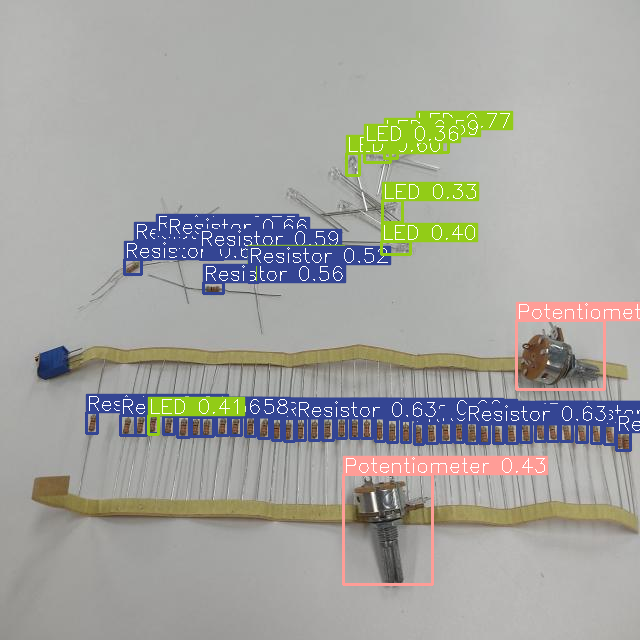

In [ ]:
from IPython.display import Image

Image("results_yolov5x6/prediction_visual.png")

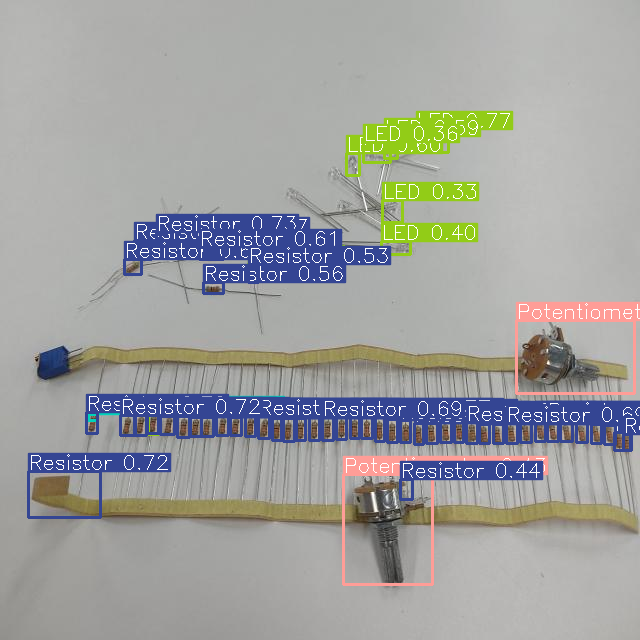

In [ ]:
from IPython.display import Image
Image("results_yolosahi/prediction_visual.png")